In [15]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import processed_pretraining_data_paths, pretrained_weights_paths
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import evaluate_weightless, train_weightless, EarlyStopper

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [17]:
BATCH_SIZE = 64

# Training Parameters
learning_rate = 1e-4
num_epochs = 10

# Base Model Parameters
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0


In [21]:
datasets = {
    "jena_climate": {
        "metrics": ["T (degC)"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["jena_climate"]["train"],
        "val_path": processed_pretraining_data_paths["jena_climate"]["eval"],
    },
    "ettm1": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["ettm1"]["train"],
        "val_path": processed_pretraining_data_paths["ettm1"]["eval"],
    },
    "ettm2": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["ettm2"]["train"],
        "val_path": processed_pretraining_data_paths["ettm2"]["eval"],
    },
    "etth1": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["etth1"]["train"],
        "val_path": processed_pretraining_data_paths["etth1"]["eval"],
    },
    "etth2": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["etth2"]["train"],
        "val_path": processed_pretraining_data_paths["etth2"]["eval"],
    },
    "illness": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["illness"]["train"],
        "val_path": processed_pretraining_data_paths["illness"]["eval"],
    },
    "psm": {
        "metrics": None,
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["psm"]["train"],
        "val_path": processed_pretraining_data_paths["psm"]["eval"],
    },
    "swat": {
        "metrics": None,
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["swat"]["train"],
        "val_path": processed_pretraining_data_paths["swat"]["eval"],
    },
    "exchange_rate": {
        "metrics": ["OT"],
        "shift": 1,
        "window_length": 5,
        "train_path": processed_pretraining_data_paths["exchange_rate"]["train"],
        "val_path": processed_pretraining_data_paths["exchange_rate"]["eval"],
    },
}

results = {
    dataset: {
        "train_losses": [],
        "train_r2_scores": [],
        "eval_losses": [],
        "eval_r2_scores": [],
    }
    for dataset in datasets
}

progress_bar = tqdm(range(num_epochs * len(datasets)))

for dataset, properties in datasets.items():
    # Load Data
    train_df = pd.read_csv(properties["train_path"])
    val_df = pd.read_csv(properties["val_path"])

    n_features = len(train_df.columns)
    metrics = properties["metrics"] if metrics is not None else train_df.columns

    # Prepare Dataset
    train_dataset = TimeSeriesDataset(
        train_df,
        metrics=metrics,
        window_length=properties["window_length"],
        shift=properties["shift"],
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=properties["window_length"]), ToTensor()]
        ),
    )

    val_dataset = TimeSeriesDataset(
        val_df,
        metrics=metrics,
        window_length=properties["window_length"],
        shift=properties["shift"],
        transform=transforms.Compose(
            [ToNumpy(), PadAndMask(pad_length=properties["window_length"]), ToTensor()]
        ),
    )

    # Prepare Dataloader
    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )
    eval_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

    # Build Model
    model = TimeSeriesTransformerModel(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        dropout=dropout,
        device=device,
    )
    model = model.to(device)

    # Train
    early_stopper = EarlyStopper(patience=3)
    num_training_steps = num_epochs * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(num_epochs):
        train_loss, train_r2_score = train_weightless(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            device=device,
        )
        results[dataset]["train_losses"].append(train_loss)
        results[dataset]["train_r2_scores"].append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weightless(model, eval_dataloader, device=device)
        results[dataset]["eval_losses"].append(eval_loss)
        results[dataset]["eval_r2_scores"].append(eval_r2_score)

        if early_stopper.early_stop(eval_loss):
            print("Early stopping!")
            progress_bar.update(num_epochs - epoch)
            break

        progress_bar.update(1)

    # Save incremental results
    torch.save(model.state_dict(), pretrained_weights_paths[dataset])

progress_bar.close()

100%|██████████| 10/10 [13:19<00:00, 80.00s/it]


In [22]:
torch.save(model.state_dict(), pretrained_weights_paths["all"])

In [23]:
# Inspect results
dataset = "jena_climate"
train_losses = results[dataset]["train_losses"]
train_r2_scores = results[dataset]["train_r2_scores"]
eval_losses = results[dataset]["eval_losses"]
eval_r2_scores = results[dataset]["eval_r2_scores"]


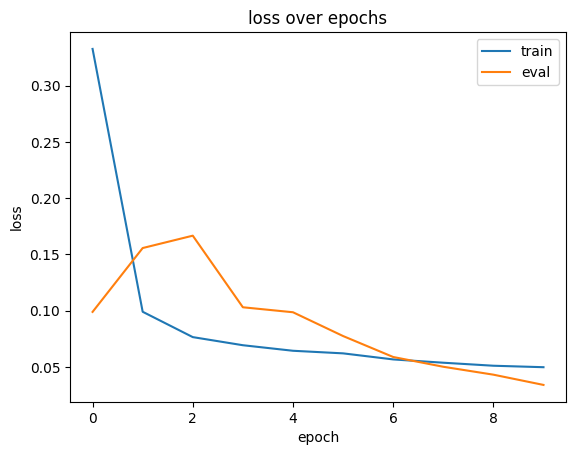

In [24]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

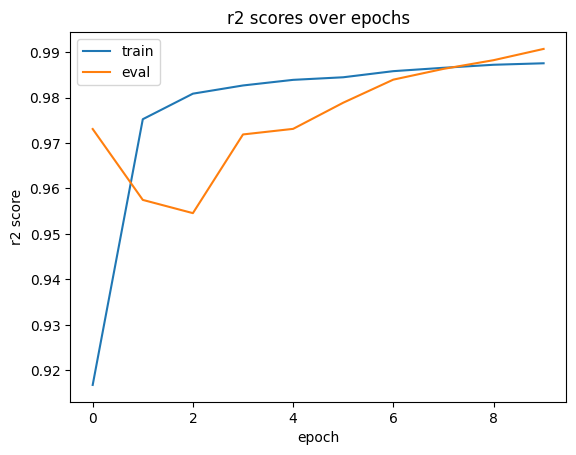

In [25]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()